# Modelo de Ising 2D

#### Santiago Marín Agudelo

#### Instituto de física, Universidad de Antioquia

<h2><left>Resumen</left></h2>
<div style="text-align:justify"> 
    
En este notebook se aborda el problema del modelo de Ising en dos dimensiones, se desarrollan algoritmos que escriben todas las configuraciones (microestados) del sistema, para posteriormente calcular las energías de los mismos y sus degeneraciones, posteriormente se grafican curvas de calor específico con los resultados obntenidos y se hace un pequeño análisis del costo computacional.
Luego en una segunda parte, por métodos montecarlo se abarca el problema de tamaños de sistema alto dimensionales y se observan transiciones entre estados paramagnéticos y ferromagnéticos.
</div>

<div style="text-align:justify"> 

Palabras clave ( Modelo de Ising, Temperatura de Courie, Métodos Monte Carlo)

</div>

In [1]:
from IPython.display import Image
import random
import math
import numpy as np
import pandas as pd
from pandas import set_option
import re
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings("ignore")
from time import time
%matplotlib inline

<h2><left>1. Introducción</left></h2>
<div style="text-align:justify"> 
    


El modelo de Ising es un modelo físico que permite estudiar la interacción entre espínes, fue propuesto originalmente por el físico Wilhem Lenz en el año 1920 como un problema para su estudiante Ernst Ising quien lo resolvió en el año 1924 [1] 


</div>

<div style="text-align:justify"> 

El modelo es bastante útil pues tiene solución analítica y adicionalmente permite modelar diferentes situaciones no necesariamente físicas, puede pensarse el modelo como la interacción de agentes, cuyas decisiones tienen dos posibilidades (arriba o abajo). En este informe se trabajará el modelo de ising 2D, es decir, arreglos cuadrados de la forma $LxL$ donde $L$ es un número entero. Un ejemplo de una red de este tipo se ve en la siguiente figura donde $L=4$

</div>

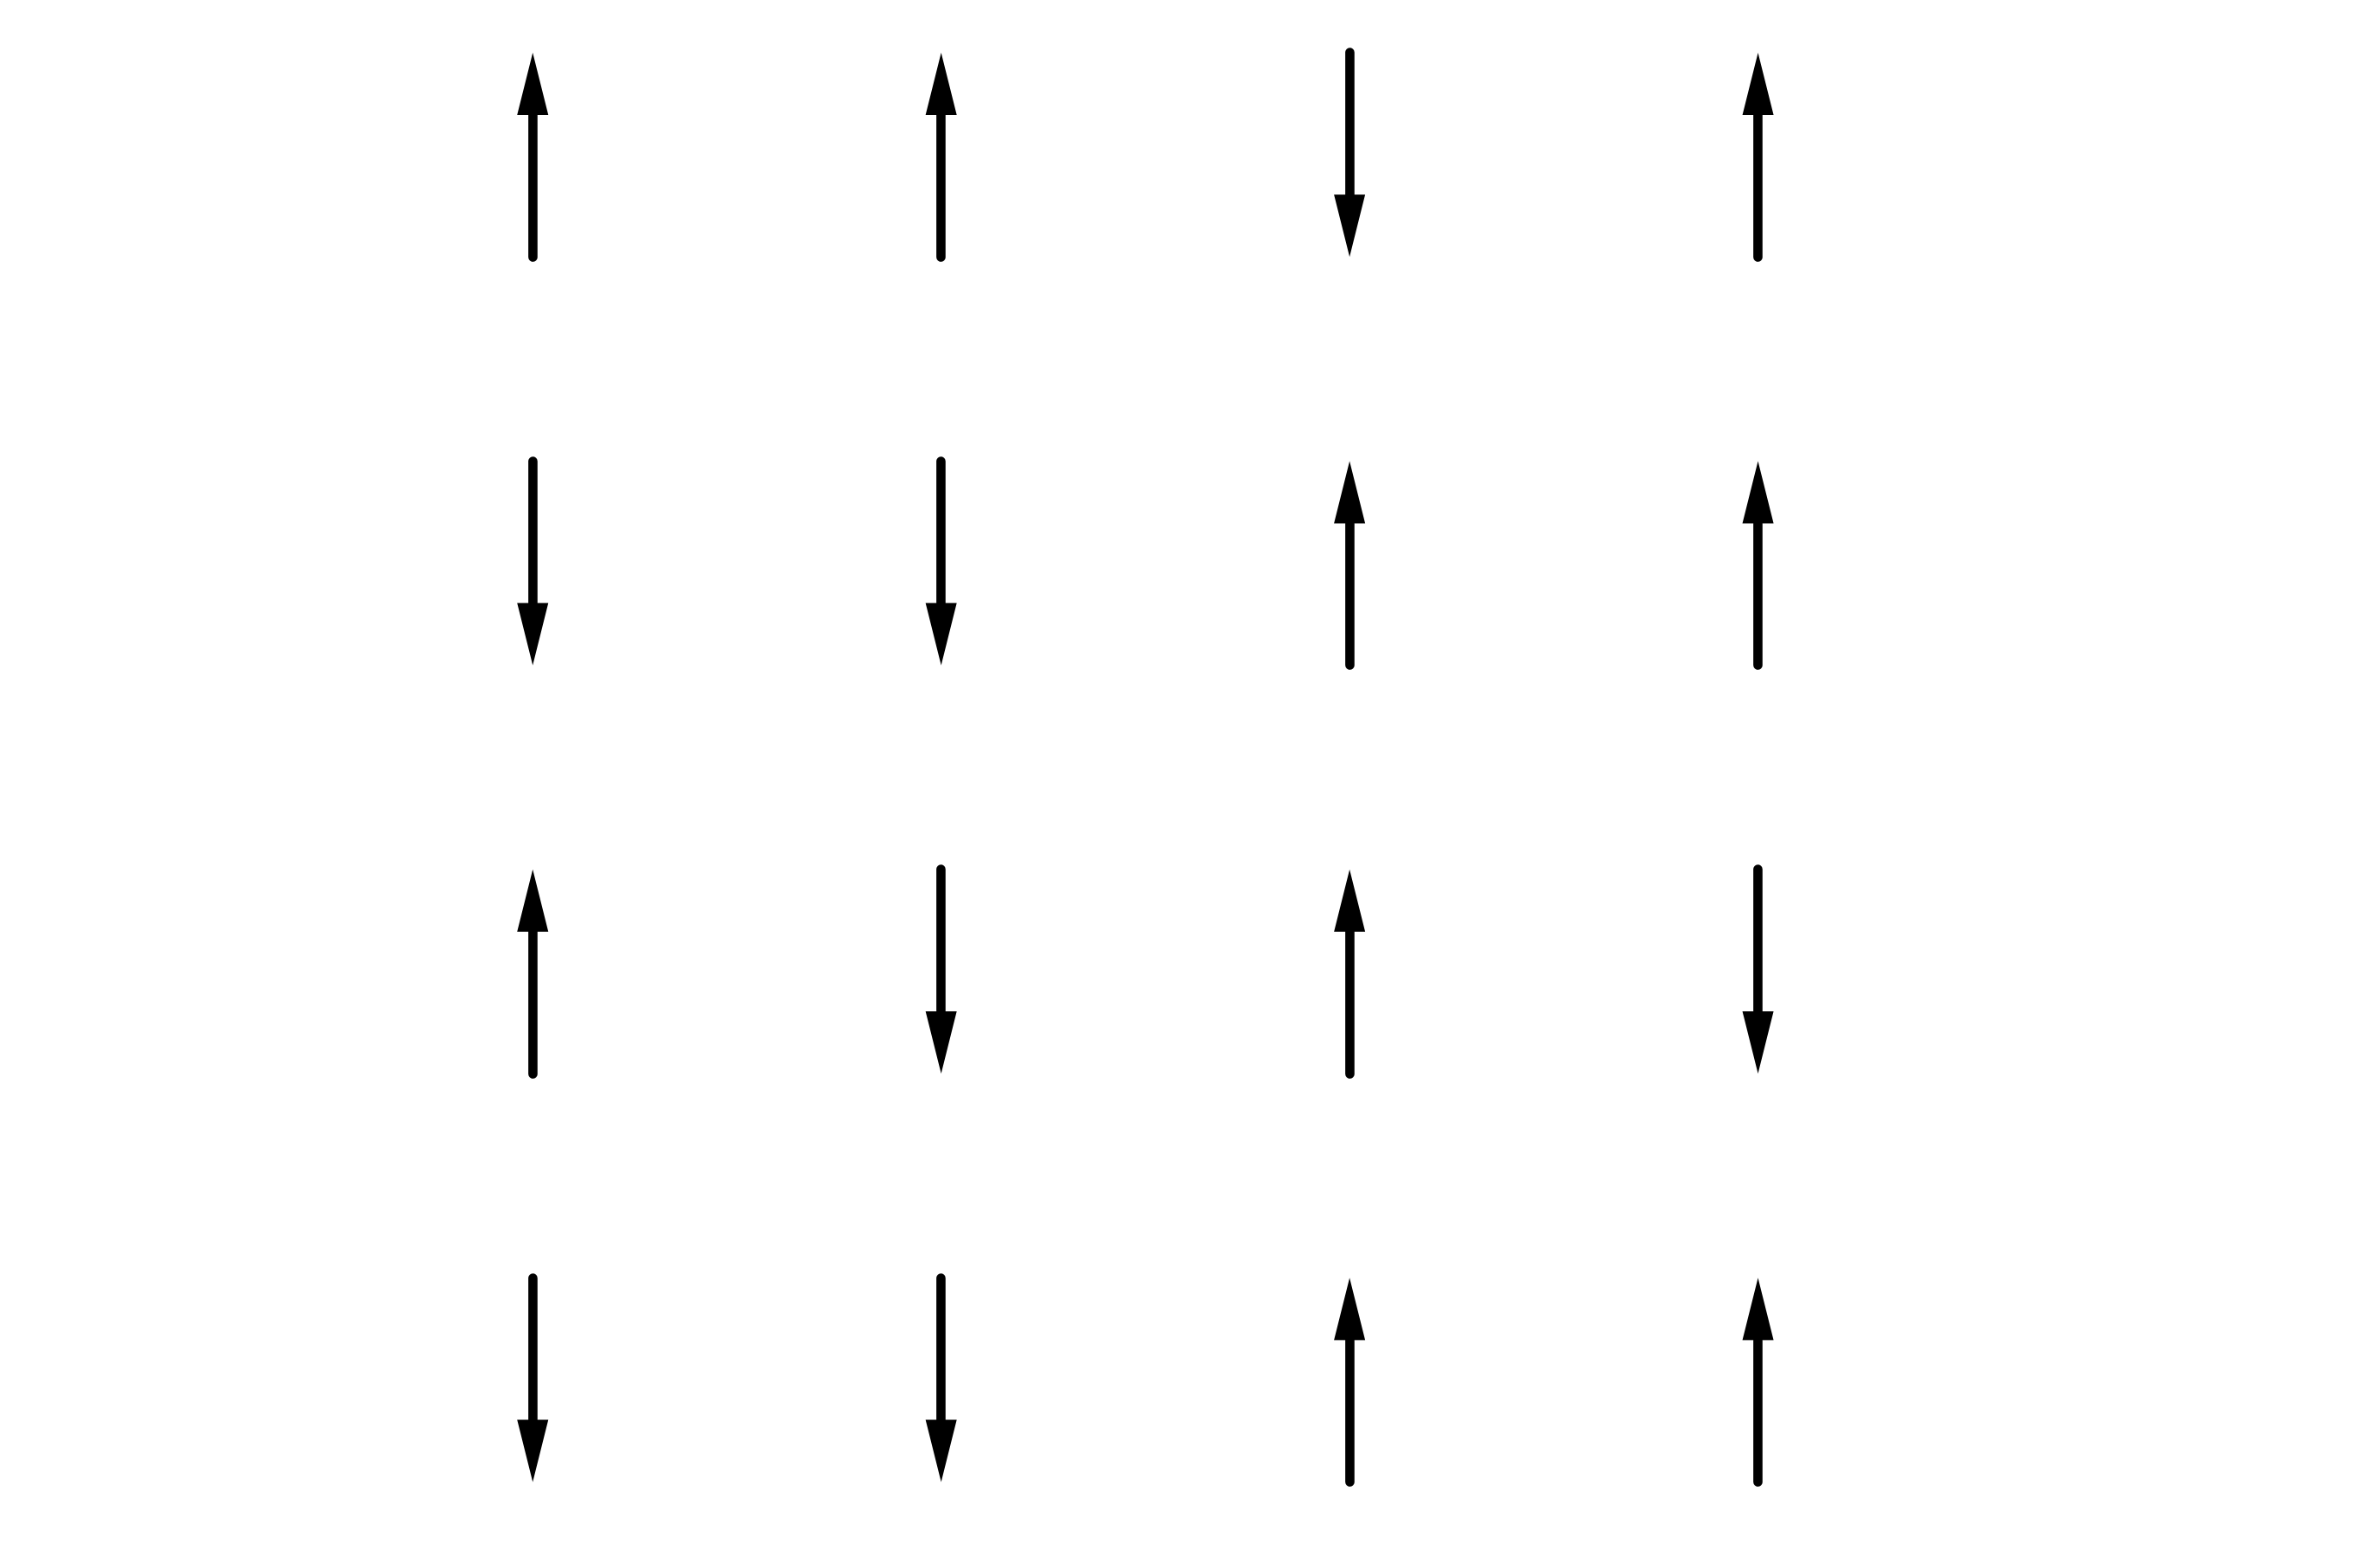

In [2]:
Image(filename = "ising3x3.png", width=500)

<div style="text-align:justify"> 
    
El modelo de Ising que se trata en este informe es descrito por el siguiente Hamiltoniano $\mathbb{H} = -\sum\limits_{<i,j>} J_{ij}\sigma_i\sigma_j$  donde $I_{ij}$ es una integral múltiple de la forma

$$  J_{ij} (r_{ij}) = \iint \frac{\psi_i(\vec{r_i})\psi_j(\vec{r_j})z^2 e^2 \psi_i^*(\vec{r_j})\psi_j^*(\vec{r_i}) \,d^3\vec{r_i}\,d^3\vec{r_j}}{|\vec{r_i}-\vec{r_j}|^2}  $$

Para el caso aquí descrito el valor que adoptaremos para $J_{ij}=J$ será de $J=1$ y $\sigma_i\sigma_j = -1$ para espínes paralelos y $1$ para cuando son antiparalelos 



</div>

<div style="text-align:justify"> 
    
Este informe abordará el problema de manera algorítmica en dos fases diferentes:

$$$$
   1. Primero será abordado el problema de construir todos los microestados posibles que aparecen en una red de tamaño $LxL$ y contarlos, es decir, lo que queremos es conocer la dimensión de la suma que aparece en la función de partición canónica para el modelo objeto de estudio (Donde $N=LxL$) $$Z = \sum\limits_r e^{-\beta E_r(N)}$$ Para luego usar el Hamiltoniano descrito arriba y calcular los valores en energía para cada microestado cuando la red tiene condiciones de frontera periódica, además de sus respectivas degenraciones y por último construir curvas de calor específico usando el resultado del teorema de fluctuación disipación $$c_v = \frac{\beta^2}{N}(<E^2> - <E^2>)$$ Por último se hará un análisis de los costos computacionales de todo este proceso. Resaltando que siempre se hará esto para sistemas pequeños, es decir, que tengan tiempos de computo razonables.



</div>

<div style="text-align:justify"> 
    
   2. Posteriormente se usarán métodos Monte Carlo unidos al método de Metrópolis para modelar sistemas más grandes que parten de una configuración inicial y junto a la temperatura crítica de Courie observar transiciones entre estados ferromagnéticos y paramagnéticos. En el método de Metrópolis se busca hacer cambios de estados como el descrito en la siguiente figura



</div>

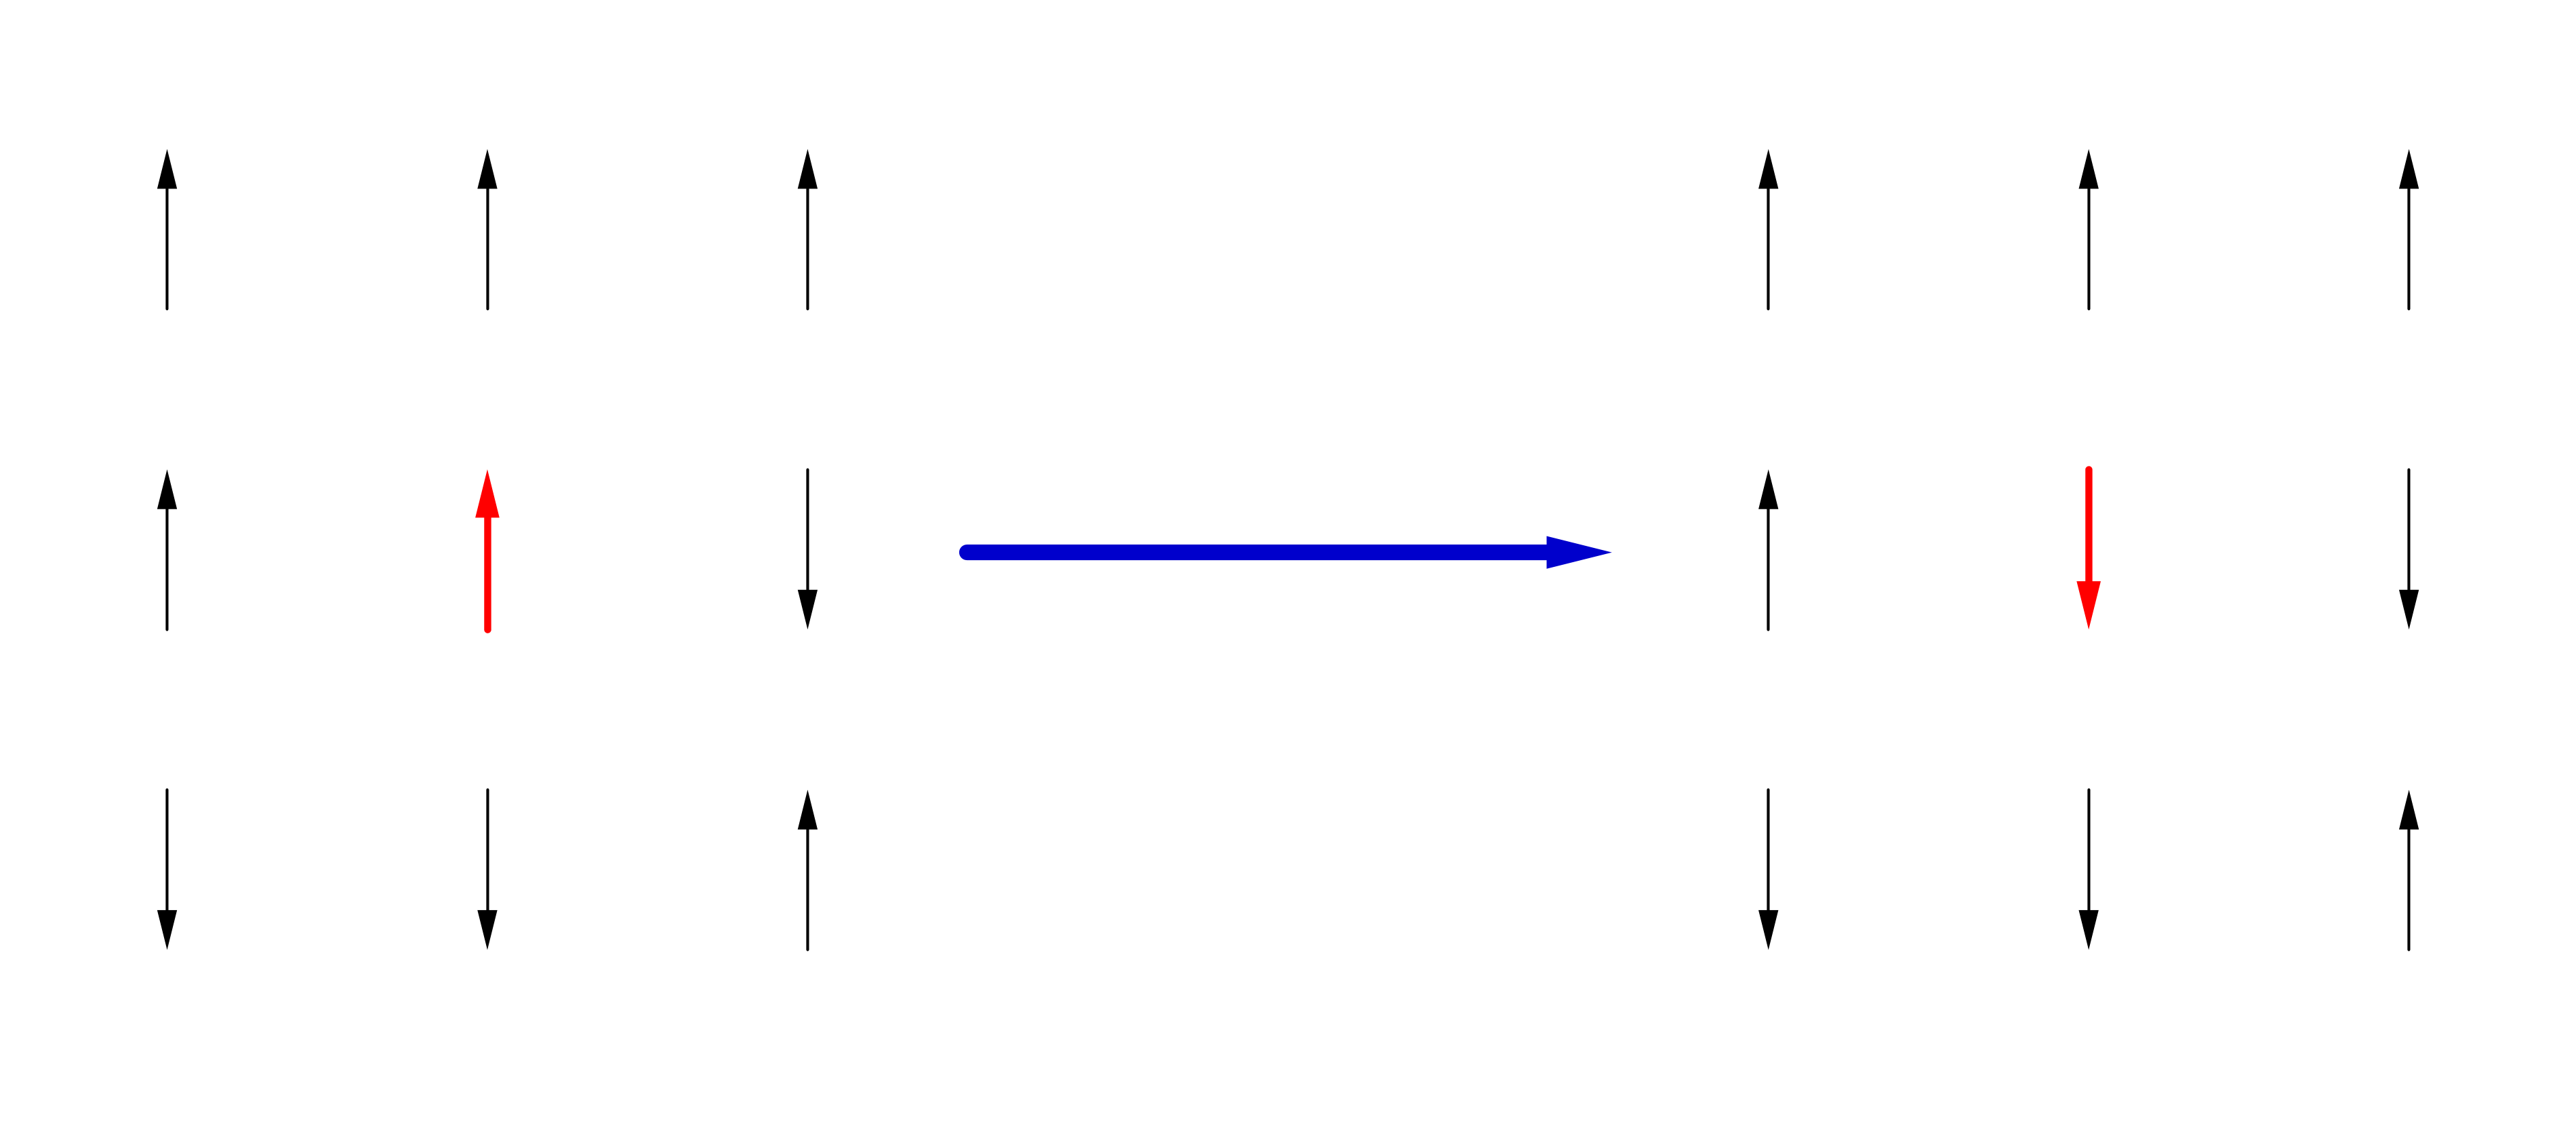

In [3]:
Image(filename = "ising3x3MC.png", width=800)

<h2><left>2. Resultados y discusión</left></h2>
<div style="text-align:justify"> 


</div>

### Parte 1

<div style="text-align:justify"> 
    
Abordemos primero el problema de generar las combinaciones posibles para una red de $N=LxL$ espínes, para esto usaremos un generador de permutaciones en orden Lexicográfico llamado algoritmo L y disponible en [2] 

Note que al usar el algortimo L más adelante, se trabaja generando primero los espínes hacia abajo ($-1$), pues este funciona teniendo la secuencia inicial en orden creciente.

</div>

In [4]:
#Esta función será usada para generar las permutaciones posibles de los spines arriba o abajo
# como se explica en el link de abajo

#http://blog.bjrn.se/2008/04/lexicographic-permutations-using.html



def cmp(a, b):
    return (a > b) - (a < b)

def next_permutation(seq, pred= cmp):  
    """Like C++ std::next_permutation() but implemented as
    generator. Yields copies of seq."""
    def reverse(seq, start, end):
        # seq = seq[:start] + reversed(seq[start:end]) + \
        #       seq[end:]
        end -= 1
        if end <= start:
            return
        while True:
            seq[start], seq[end] = seq[end], seq[start]
            if start == end or start+1 == end:
                return
            start += 1
            end -= 1
    if not seq:
        raise StopIteration
    try:
        seq[0]
    except TypeError:
        raise TypeError("seq must allow random access.")
    first = 0
    last = len(seq)
    seq = seq[:]
    # Yield input sequence as the STL version is often
    # used inside do {} while.
    yield seq[:]
    if last == 1:
        raise StopIteration
    while True:
        next = last - 1
        while True:
            # Step 1.
            next1 = next
            next -= 1
            if pred(seq[next], seq[next1]) < 0:
                # Step 2.
                mid = last - 1
                while not (pred(seq[next], seq[mid]) < 0):
                    mid -= 1
                seq[next], seq[mid] = seq[mid], seq[next]
                # Step 3.
                reverse(seq, next1, last)
                # Change to yield references to get rid of
                # (at worst) |seq|! copy operations.
                yield seq[:]
                break
            if next == first:
                raise StopIteration
    raise StopIteration

<div style="text-align:justify"> 

Veamos algunos ejemplos del funcionamiento del algoritmo

</div>

In [5]:
#Ejemplo funcionamiento

for p in next_permutation([int(c) for c in "1223"]):
    print(p)

[1, 2, 2, 3]
[1, 2, 3, 2]
[1, 3, 2, 2]
[2, 1, 2, 3]
[2, 1, 3, 2]
[2, 2, 1, 3]
[2, 2, 3, 1]
[2, 3, 1, 2]
[2, 3, 2, 1]
[3, 1, 2, 2]
[3, 2, 1, 2]
[3, 2, 2, 1]


In [6]:
#Ejemplo funcionamiento

list(next_permutation([str(c) for c in "asz"]))

[['a', 's', 'z'],
 ['a', 'z', 's'],
 ['s', 'a', 'z'],
 ['s', 'z', 'a'],
 ['z', 'a', 's'],
 ['z', 's', 'a']]

In [7]:
#Ejemplo de funcionamiento
N=3
for i in range(0,N+1): #los intervalos en python son abiertos          
        permutaciones =list(next_permutation([-1]*i+[1]*(N-i))) #En este orden para empezar en -1-1-1-1 y terminar en 1111
        print(permutaciones)
        #permut.append(permutaciones)

[[1, 1, 1]]
[[-1, 1, 1], [1, -1, 1], [1, 1, -1]]
[[-1, -1, 1], [-1, 1, -1], [1, -1, -1]]
[[-1, -1, -1]]


In [57]:
#Ejemplo de funcionamiento
N=4
for i in range(0,N+1): #los intervalos en python son abiertos          
        permutaciones =list(next_permutation([-1]*i+[1]*(N-i))) #En este orden para empezar en -1-1-1-1 y terminar en 1111
        print(permutaciones)
        #permut.append(permutaciones)

[[1, 1, 1, 1]]
[[-1, 1, 1, 1], [1, -1, 1, 1], [1, 1, -1, 1], [1, 1, 1, -1]]
[[-1, -1, 1, 1], [-1, 1, -1, 1], [-1, 1, 1, -1], [1, -1, -1, 1], [1, -1, 1, -1], [1, 1, -1, -1]]
[[-1, -1, -1, 1], [-1, -1, 1, -1], [-1, 1, -1, -1], [1, -1, -1, -1]]
[[-1, -1, -1, -1]]


In [8]:
#Ejemplo funcionamiento, problema de la secuencia inicial no ser creciente

for p in next_permutation([int(c) for c in "213"]):
    print(p)

[2, 1, 3]
[2, 3, 1]
[3, 1, 2]
[3, 2, 1]


<div style="text-align:justify"> 
    
Ahora nos concentraremos en el problema de calcular la energía para cada microestado usando el Hamiltoniano descrito más arriba. En este problema, obsérvese que para el caso de la red de $2x2$ se debe de tener especial cuidado en el conteo de vecinos repetidos.

</div>


In [9]:
#Cálculo de las energías en cada posición para una red e L*L

def Energias(L):     #L*L número de spines en la red                 
    Energias=[]
    N=L*L                             #Spines que se usaran para formar la red de N=LxL spines (arriba o abajo)
    for i in range(0,N+1):            
        
        permutaciones=list(next_permutation([-1]*i+[1]*(N-i)))
        c=0
        for i in permutaciones:
            permutaciones[c]=np.reshape(i,(L,L))          #Inicialmente se tiene una permutación 'lineal' (vector)
            c+=1                                         # Se convierte esta en una red LxL con la orden reshape
            
            
        for k in permutaciones:                       #Suma energías usando el Hamiltoniano con J=1 
            Energia=0                         #Recordar que estamos trabajando una red LxL
            for i in range(L):             # i: filas, j: columnas              
                for j in range(L):  #Vamos a definir los vecinos que debe de visitar
              #para el spin en la posición i,j de la red
                    r=j+1     #vecino derecho
                    u=i-1   #Vecino de arriba
                    d=i+1    #vecino de abajo
                    l=j-1      #vecino izquierdo
                                                            #Frontera periódica                   
                    if u<0:       #significa que está en la fila mas arriba de la red                  
                        u= L-1   # ( su vecino estara en la fila mas baja)
                    if d>L-1:    #significa que está en la  última fila  de la red
                        d=0       #  ( su vecino estara en la primera fila)
                    if r>L-1:     #significa que está en la  última columna  de la red
                        r=0       # ( su vecino estara en la primera columna)
                    if l<0:         #significa que está en la  primera columna  de la red
                        l=L-1     # ( su vecino estara en la última columna)
                        
                        #Así usando el Hamiltoniano podemos calcular las energias como 
                    Energia=Energia-k[i][j]*k[u][j]-k[i][j]*k[d][j]-k[i][j]*k[i][r]-k[i][j]*k[i][l] #
            Energia=Energia/2       #Eliminación conteos repetidos
            if L==2:
                Energia = Energia/2
             #Para el caso de la red 2x2 el conteo no es doble sino cuadruple, porque el vecino de abajo y el e
            #arriba son el mismo, igualmente con el vecino izquierdo y derecho
            Energias.append(Energia)
    return Energias    




<div style="text-align:justify"> 

Para comprobar el funcionamiento del código, calcularemos las energías de ciertos estados particulares de una red de $4x4$ espínes, los valores correspondientes de sus energías se encontraban en el material disponible para el desarrollo de este informe, puede verse que efectivamente se está calculando bien el valor de la energía

</div>


In [10]:
L = 4
Energiass=[]
c=0
permutaciones=[[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],[1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],[1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],[-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],[-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]] 
        
for i in permutaciones:
            permutaciones[c]=np.reshape(i,(L,L))          #Inicialmente se tiene una permutación 'lineal' (vector)
            c+=1  

            
for k in permutaciones:                       #Suma energías usando el Hamiltoniano con J=1 
            Energia=0                         #Recordar que estamos trabajando una red LxL
            for i in range(L):             # i: filas, j: columnas              
                for j in range(L):  #Vamos a definir los vecinos que debe de visitar
              #para el spin en la posición i,j de la red
                    r=j+1     #vecino derecho
                    u=i-1   #Vecino de arriba
                    d=i+1    #vecino de abajo
                    l=j-1      #vecino izquierdo
                                                            #Frontera periódica                   
                    if u<0:       #significa que está en la fila mas arriba de la red                  
                        u= L-1   # ( su vecino estara en la fila mas baja)
                    if d>L-1:    #significa que está en la  última fila  de la red
                        d=0       #  ( su vecino estara en la primera fila)
                    if r>L-1:     #significa que está en la  última columna  de la red
                        r=0       # ( su vecino estara en la primera columna)
                    if l<0:         #significa que está en la  primera columna  de la red
                        l=L-1     # ( su vecino estara en la última columna)
                        
                        #Así usando el Hamiltoniano podemos calcular las energias como 
                    Energia=Energia-k[i][j]*k[u][j]-k[i][j]*k[d][j]-k[i][j]*k[i][r]-k[i][j]*k[i][l] #
            Energia=Energia/2       #Eliminación conteos repetidos
            if L==2:
                Energia = Energia/2
             #Para el caso de la red 2x2 el conteo no es doble sino cuadruple, porque el vecino de abajo y el e
            #arriba son el mismo, igualmente con el vecino izquierdo y derecho
            Energiass.append(Energia)
print("")
print("")
print("El valor de las energías para los 5 microestados analizados es:",Energiass)
print("")




El valor de las energías para los 5 microestados analizados es: [-32.0, -24.0, -20.0, -24.0, -20.0]



<div style="text-align:justify"> 

Como un ejemplo más, calculemos los valores de la energía de la red $2x2$, los cuales fueron trabajados en clase

</div>

In [11]:
Energias(2) #Ejemplo de clase

[-4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -4.0]

<div style="text-align:justify"> 

Podemos ahora calcular las degeneraciones para cada valor de la energía en la red de espínes así como la respectiva función partición y analizar los resultados obtenidos
</div>

In [12]:
#En esta celda se escriben las funciones para el calculo de Omega y sus valores correspondientes y la función partición                  
def OmegaE(E):
    EnergiasDiferentes=[]
    Omega=[]
    for i in E:                               
        if i not in EnergiasDiferentes:  #Agrupar energías distintas en el vector de energías de los microestados
            EnergiasDiferentes.append(i)
    for j in EnergiasDiferentes:                   
        c=0 #Contador
        for k in E:
            if k==j:
                c+=1
        Omega.append(c)
    EvsO=[]
    for m in range(len(EnergiasDiferentes)):  #Construcción tabla E vs Omega
        EvsO.append([EnergiasDiferentes[m],Omega[m]])
    return EvsO   

#Cálculo de la función partición
def Zparticion(EvsO,T):
   # EvsO=np.array(EvsO)
    Z = 0
   
    #EvsO = pd.DataFrame(EvsO)
    #EvsO.columns = ['Energía','Omega']
    for i in EvsO:
        Z = Z + (i[1])*(np.exp(-(1.0/T)*(i[0])))
    return Z


<div style="text-align:justify"> 

Veamos, usando dataframes como se distribuyen los valores para 3 tamaños diferentes del sistema
</div>

In [13]:
T = pd.DataFrame(OmegaE(Energias(2)))
T.columns = ['Energía','Omega']
T

,Energía,Omega
0,-4.0,2
1,0.0,12
2,4.0,2


In [14]:
H = pd.DataFrame(OmegaE(Energias(3)))
H.columns = ['Energía','Omega']
H

,Energía,Omega
0,-18.0,2
1,-10.0,18
2,-6.0,48
3,-2.0,198
4,2.0,144
5,6.0,102


In [15]:
O = pd.DataFrame(OmegaE(Energias(4)))
O.columns = ['Energía','Omega']
O

,Energía,Omega
0,-32.0,2
1,-24.0,32
2,-20.0,64
3,-16.0,424
4,-12.0,1728
5,-8.0,6688
6,-4.0,13568
7,0.0,20524
8,4.0,13568
9,8.0,6688


<div style="text-align:justify"> 

Se nota un comportamiento gaussiano de la data modelada.

Obtengamos ahora histogramas de dichas degeneraciones con los datos obtenidos para observar mejor este comportamiento (también guardaremos los tiempos computacionales del cálculo) y adicionalmente calculemos la función partición para cada tamaño de sistema

</div>

In [16]:
ti2=time()

EvsO2x2=pd.DataFrame(OmegaE(Energias(2)))
EvsO2x2.columns = ['Energía','Omega']
                           
tf2=time()

Delta2 = tf2 - ti2

ti3=time()

EvsO3x3=pd.DataFrame(OmegaE(Energias(3)))
EvsO3x3.columns = ['Energía','Omega']
                           
tf3=time()

Delta3 = tf3 - ti3


ti4=time()

EvsO4x4=pd.DataFrame(OmegaE(Energias(4)))
EvsO4x4.columns = ['Energía','Omega']
                           
tf4=time()

Delta4 = tf4 - ti4


Text(0.5,1,'$E$ vs $\\Omega(E)$ para $N=2x2$')

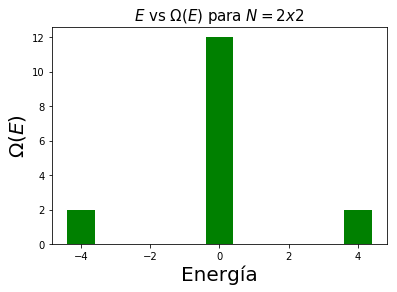

In [17]:
plt.bar(EvsO2x2.iloc[:,0], height=EvsO2x2.iloc[:,1],color='g')
plt.ylabel('$\Omega(E)$',fontsize=20)
plt.xlabel('Energía',fontsize=20)
plt.title( '$E$ vs $\Omega(E)$ para $N=2x2$', fontsize=15)

Text(0.5,1,'$E$ vs $\\Omega(E)$ para $N=3x3$')

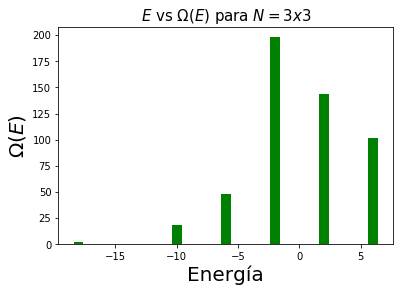

In [18]:
plt.bar(EvsO3x3.iloc[:,0], height=EvsO3x3.iloc[:,1],color='g')
plt.ylabel('$\Omega(E)$',fontsize=20)
plt.xlabel('Energía',fontsize=20)
plt.title( '$E$ vs $\Omega(E)$ para $N=3x3$', fontsize=15)

Text(0.5,1,'$E$ vs $\\Omega(E)$ para $N=4x4$')

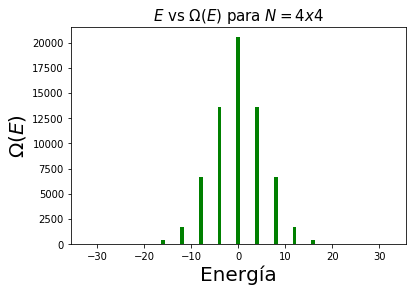

In [19]:
plt.bar(EvsO4x4.iloc[:,0], height=EvsO4x4.iloc[:,1],color='g')
plt.ylabel('$\Omega(E)$',fontsize=20)
plt.xlabel('Energía',fontsize=20)
plt.title( '$E$ vs $\Omega(E)$ para $N=4x4$', fontsize=15)

In [20]:
Z2 = Zparticion(OmegaE(Energias(2)),1)
Z3 = Zparticion(OmegaE(Energias(3)),1)
Z4 = Zparticion(OmegaE(Energias(4)),1)
print('Función partición para N = 2x2',str(Z2))
print('Función partición para N = 3x3',str(Z3))
print('Función partición para N = 4x4',str(Z4))

Función partición para N = 2x2 121.23293134406595
Función partición para N = 3x3 131737262.0152763
Función partición para N = 4x4 158808692495372.3




Antes de continuar a graficar las curvas de calor específico respecto a su temperatura demostremos la validez de la formula presentada más arriba que es:

$$c_v = \frac{\beta^2}{N}(<E^2> - <E^2>)$$

Por el postulado de compatibilidad de la física estadística y la termodinámica se tiene que 

$$ c_{v}=\frac{\partial U}{\partial T}= \frac{\partial \langle E \rangle}{\partial T}$$

Usando la regla de la cadena en terminos de la variable $\beta$, obtenemos la siguiente expresión:

$$c_{v}= \frac{\partial \langle E \rangle}{\partial \beta}\frac{\partial \beta}{\partial T}$$

Debido a que $c_v$ es una propiedad extensiva podemos hacer el siguiente reemplazamiento

$$c_{v}=\frac{-\beta^2}{N}\frac{\partial \langle E \rangle}{\partial \beta}=\frac{-\beta^2}{N}\frac{\partial }{\partial \beta}\left( \frac{\sum\limits_{r}E_{r}e^{-\beta E_{r}}}{\sum_{r}e^{-\beta E_{r}}} \right)=\frac{\beta^2}{N}\frac{\sum_{r}E_{r}^{2}e^{-\beta E_{r}}\sum_{r}e^{-\beta E_{r}} - \left(\sum_{r}E_r e^{-\beta E_{r}}\right)^{2}}{\left(\sum_{r}e^{-\beta E_{r}}\right)^{2}},$$

Observe que el denominador de la última expresión corresponde a la función partición (eleveada al cuadrado) y en los sumatorios del numerador se encuentran las expresiones necesarias para el cálculo de $<E>$ y $<E^2>$ y asi obtenemos la expresión buscada

<div style="text-align:justify"> 

Grafiquemos ahora las curvas de calor específico, primero calculamos $<E>$ y $<E^2>$ de acuerdo a sus expresiones en la colectividad canónica y luego usamos sus valores para construir los gráficos

</div>


In [21]:
#Cálculo de la función partición
def Zparticion1(EvsO,T):
   # EvsO=np.array(EvsO)
    Z = 0
   

    for i in EvsO:
        Z = Z + (i[1])*(np.exp(-(1.0/T)*(i[0])))
    return Z

def Eexpected(EvsO,T): 
   # EvsO=np.array(EvsO)

    e=0
    for i in EvsO:
        e = e + i[1]*i[0]*(np.exp(-1.0*(i[0]/T)))
    return e/Zparticion1(EvsO,T)

def Esqrexpected(EvsO,T): 
    EvsO=np.array(EvsO)
    E = EvsO[:,0]
    Omega = EvsO[:,1]
    e = 0
    for j in EvsO:
        e = e + j[1]*(j[0]**2)*(np.exp(-1.0*(j[0]/T)))
        
    return e/Zparticion1(EvsO,T)

<div style="text-align:justify"> 

Por sugerencia de un compañero, se ha omitido para el cálculo del calor específico en la red de $2x2$, la división por $4$ del conteo repetido de estados para obtener la curva, que de otra manera parecía estar errónea.

</div>

In [48]:
def Energiasoptional(L):     #L*L número de spines en la red                 
    Energias=[]
    N=L*L                             #Spines que se usaran para formar la red de N=LxL spines (arriba o abajo)
    for i in range(0,N+1):            
        
        permutaciones=list(next_permutation([-1]*i+[1]*(N-i)))
        c=0
        for i in permutaciones:
            permutaciones[c]=np.reshape(i,(L,L))          #Inicialmente se tiene una permutación 'lineal' (vector)
            c+=1                                         # Se convierte esta en una red LxL con la orden reshape
            
            
        for k in permutaciones:                       #Suma energías usando el Hamiltoniano con J=1 
            Energia=0                         #Recordar que estamos trabajando una red LxL
            for i in range(L):             # i: filas, j: columnas              
                for j in range(L):  #Vamos a definir los vecinos que debe de visitar
              #para el spin en la posición i,j de la red
                    r=j+1     #vecino derecho
                    u=i-1   #Vecino de arriba
                    d=i+1    #vecino de abajo
                    l=j-1      #vecino izquierdo
                                                            #Frontera periódica                   
                    if u<0:       #significa que está en la fila mas arriba de la red                  
                        u= L-1   # ( su vecino estara en la fila mas baja)
                    if d>L-1:    #significa que está en la  última fila  de la red
                        d=0       #  ( su vecino estara en la primera fila)
                    if r>L-1:     #significa que está en la  última columna  de la red
                        r=0       # ( su vecino estara en la primera columna)
                    if l<0:         #significa que está en la  primera columna  de la red
                        l=L-1     # ( su vecino estara en la última columna)
                        
                        #Así usando el Hamiltoniano podemos calcular las energias como 
                    Energia=Energia-k[i][j]*k[u][j]-k[i][j]*k[d][j]-k[i][j]*k[i][r]-k[i][j]*k[i][l] #
            Energia=Energia/2       #Eliminación conteos repetidos

            Energias.append(Energia)
    return Energias  

In [49]:
#Cálculo calor específico red 2x2

T1=np.linspace(0,6,300)

Eexpected2x2=np.array([Eexpected(OmegaE(Energiasoptional(2)),i) for i in T1 ])
Esqrtexpected2x2=np.array([Esqrexpected(OmegaE(Energiasoptional(2)),i) for i in T1 ])
Cv2=(Esqrtexpected2x2-Eexpected2x2*Eexpected2x2)/((T1**2)*4)

In [23]:
#Cálculo calor específico red 3x3
Eexpected3x3=np.array([Eexpected(OmegaE(Energias(3)),i) for i in T1 ])
Esqrtexpected3x3=np.array([Esqrexpected(OmegaE(Energias(3)),i) for i in T1 ])
Cv3=(Esqrtexpected3x3-Eexpected3x3*Eexpected3x3)/((T1**2)*9)

In [24]:
#Cálculo calor específico red 4x4
Eexpected4x4=np.array([Eexpected(OmegaE(Energias(4)),i) for i in T1 ])
Esqrtexpected4x4=np.array([Esqrexpected(OmegaE(Energias(4)),i) for i in T1 ])
Cv4=(Esqrtexpected4x4-Eexpected4x4*Eexpected4x4)/((T1**2)*16)

<div style="text-align:justify"> 

Para comparar con la temperatura crítica construyamos una línea recta que represente dicho valor y luego grafiquemos junto a los resultados obtenidos

</div>

In [25]:
tc = 2 / np.log(1 + np.sqrt(2)) 
cvc = np.arange(0,1,0.01)
tc = np.ones(len(cvc))*tc


In [26]:
T1=np.linspace(0,6,300)


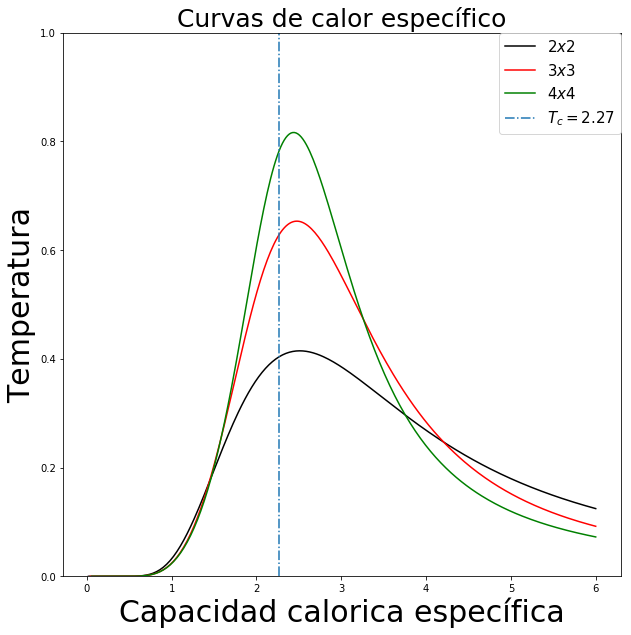

In [52]:
plt.figure(figsize=(10,10)) 


y2X2 = Cv2
y3X3 = Cv3

y4X4 = Cv4
plt.plot(T1,y2X2,label="$2 x 2$", color = 'black')
plt.plot(T1,y3X3,label="$3 x 3$", color = 'red')
plt.plot(T1,y4X4,label="$4 x 4$", color = 'green')
plt.plot(tc, cvc,linestyle='-.',label='$T_{c}=2.27$')

plt.ylim(0,1)
plt.ylabel('Temperatura',fontsize=30)
plt.xlabel('Capacidad calorica específica',fontsize=30)
plt.title(r'Curvas de calor específico',fontsize=25)
plt.legend(loc=1,borderaxespad=0.,prop={'size': 15},fontsize=18)
plt.show()

<div style="text-align:justify"> 

Por último vamos a ver ahora como es el costo computacional, medido en tiempo de compúto de nuestros métodos, para el cálculo por enumeración exacta de los microestados, las energías diferentes de las redes de espines y sus correspondientes degeneraciones.


</div>

In [76]:
Delta2 = tf2 - ti2
Delta3 = tf3 - ti3
Delta4 = tf4 - ti4
x=[4,9,16]
y=[Delta2,Delta3,Delta4]


Delta2log = np.log(tf2 - ti2)
Delta3log = np.log(tf3 - ti3)
Delta4log = np.log(tf4 - ti4)
xlog=[4,9,16]
ylog=[Delta2log,Delta3log,Delta4log]

In [92]:
m=(Delta4log - Delta2log)/12
xh=np.linspace(3.5,16.5,500)
yh = Delta4log+m*(xh-16)

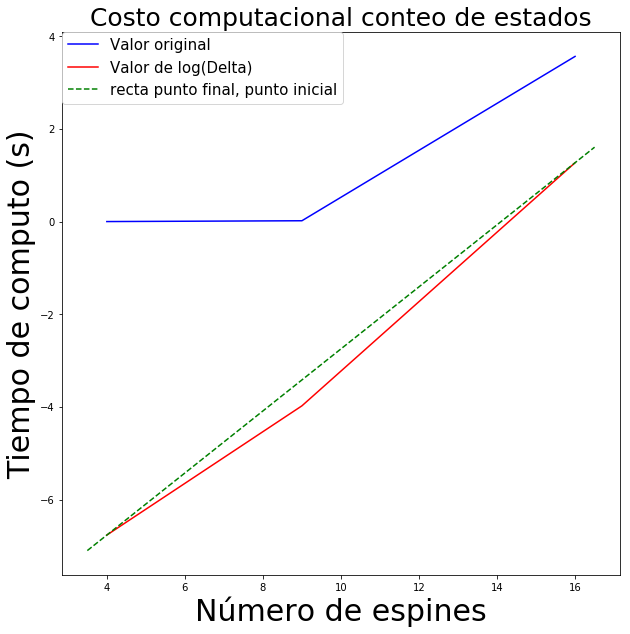

In [93]:
plt.figure(figsize=(10,10)) 


plt.plot(x,y,label="Valor original", color = 'blue')
plt.plot(xlog,ylog,label="Valor de log(Delta)", color = 'red')
plt.plot(xh,yh,label="recta punto final, punto inicial", color = 'green',linestyle = "--")

plt.ylabel('Tiempo de computo (s)',fontsize=30)
plt.xlabel('Número de espines',fontsize=30)
plt.title(r'Costo computacional conteo de estados',fontsize=25)
plt.legend(loc=2,borderaxespad=0.,prop={'size': 15},fontsize=18)
plt.show()

<div style="text-align:justify"> 

Como podemos observar el tiempo de computo se dispara para el caso de una red de $4x4$ espines, al aplicar la función $log()$ parece que el mismo es exponencial, pues su gráfico es casi una línea recta.

</div>

### Parte 2

<div style="text-align:justify"> 

Inicialmente se va a explicar las rutinas empleadas para esta parte las cuales se usaron para:


</div>

<div style="text-align:justify"> 
    
   1. Cálculo de la energía para un estado partícular y cálculo de la energía media por espín

</div>

<div style="text-align:justify"> 

   2. Lectura de una configuración inicial y escritura de una configurtación final


</div>

<div style="text-align:justify"> 

   3. Gráfica de una configuración de espínes


</div>

<div style="text-align:justify"> 

Nótese que con la segunda parte de la primer celda de código que se explicó podemos construir la siguiente función y así hacer cálculos de la energía media por espín para diferentes cantidades de pasos Monte Carlo
</div>

In [30]:
def energy(S,N,nbr): 
    E=0.0
    for k in range(N):
        E-=S[k]*sum(S[nn] for nn in nbr[k])
    return 0.5*E #Energía para una configuración específica

def Exparticula(L,T,MCsteps):
    N=L*L
    nbr={i:((i//L)*L+(i+1)%L,(i+L)%N,(i//L)*L+(i-1)%L,(i-L)%N) for i in range(N)} # frontera periódica usando diccionarios
    S=[random.choice([1,-1]) for k in range(N)] # Configuración de spines aleatoria usando random choice
    nsteps=N*MCsteps # Pasos Monte Carlo
    beta=1/T 
    Energy=energy(S,N,nbr)
    E=[]
    for step in range(nsteps): #Método de Metropolis
        k=random.randint(0,N-1)
        delta_E=2.0*S[k]*sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0,1.0)<np.exp(-beta*delta_E): # Aceptación Metropolis
                S[k]*=-1 # Spin change
                Energy+=delta_E
        E.append(Energy)
    return print('Energía media por spín con',str(MCsteps),"pasos Monte Carlo es:", sum(E)/float(len(E)*N)) #Energía media por partícula


In [31]:
Exparticula(6,2.0,100)
Exparticula(6,2.0,1000)
Exparticula(6,2.0,10000)
Exparticula(6,2.0,100000)
Exparticula(6,2.0,1000000)

Energía media por spín con 100 pasos Monte Carlo es: -1.6003086419753085
Energía media por spín con 1000 pasos Monte Carlo es: -1.7341296296296296
Energía media por spín con 10000 pasos Monte Carlo es: -1.7477123456790122
Energía media por spín con 100000 pasos Monte Carlo es: -1.7476092283950617
Energía media por spín con 1000000 pasos Monte Carlo es: -1.7470890216049382


#### Red de N=128x128 espines, T=3.0 y N*4000 iteraciones

Starting from file data_local_128_3.0.txt


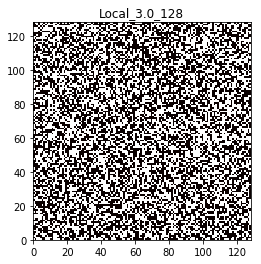

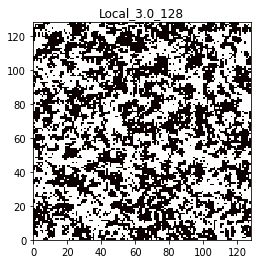

In [32]:
L=128        
N=L*L
T=3.0
nsteps=4000*N

filename="data_local_"+str(L)+"_"+str(T)+".txt" 
if os.path.isfile(filename):
    f=open(filename,"r")
    S=[]
    for line in f:
        S.append(int(line))
    f.close()
    print("Starting from file",filename)
else:
    S=[random.choice([-1,1]) for k in range(N)]
    print("Starting from a random configuration")
f=open(filename,"w")
for a in S: 
    f.write(str(a)+'\n')
f.close()

def x_y(k,L): 
    y=k//L
    x=k-y*L
    return x,y

conf=[[0 for x in range(L)] for y in range(L)] 
for k in range(N):
    x,y=x_y(k,L)
    conf[x][y]=S[k]

plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

E=[]
beta=1/T
nbr={i:((i//L)*L+(i+1)%L,(i+L)%N,(i//L)*L+(i-1)%L,(i-L)%N) for i in range(N)}

Energy=energy(S,N,nbr)

for step in range(nsteps): 
        k=random.randint(0,N-1)
        delta_E=2.0*S[k]*sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0,1.0)<np.exp(-beta*delta_E): 
            S[k]*=-1 
            Energy+=delta_E
        E.append(Energy) 

for k in range(N): 
    x,y=x_y(k,L)
    conf[x][y]=S[k]
    
plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

<div style="text-align:justify"> 

Se observa que para valores por encima de la temperatura crítica la configuración de espines al hacerla evolucionar a un estado final continúa siendo una configuración aleatoria
</div>

#### Red de N=128x128 espines, T=Tc=2.27 y N*1000 iteraciones

Starting from file data_local_128_2.27.txt


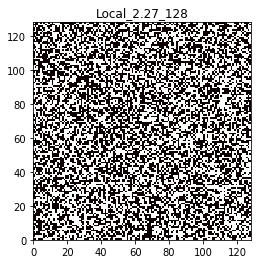

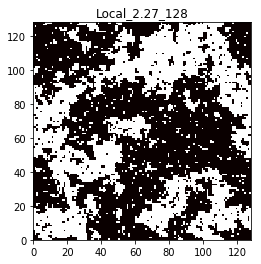

In [33]:
L=128        
N=L*L
T=2.27
nsteps=1000*N

filename="data_local_"+str(L)+"_"+str(T)+".txt" 
if os.path.isfile(filename):
    f=open(filename,"r")
    S=[]
    for line in f:
        S.append(int(line))
    f.close()
    print("Starting from file",filename)
else:
    S=[random.choice([-1,1]) for k in range(N)]
    print("Starting from a random configuration")
f=open(filename,"w")
for a in S: 
    f.write(str(a)+'\n')
f.close()

conf=[[0 for x in range(L)] for y in range(L)] 
for k in range(N):
    x,y=x_y(k,L)
    conf[x][y]=S[k]

plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

E=[]
beta=1/T
nbr={i:((i//L)*L+(i+1)%L,(i+L)%N,(i//L)*L+(i-1)%L,(i-L)%N) for i in range(N)}

Energy=energy(S,N,nbr)

for step in range(nsteps): 
        k=random.randint(0,N-1)
        delta_E=2.0*S[k]*sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0,1.0)<np.exp(-beta*delta_E): 
            S[k]*=-1 
            Energy+=delta_E
        E.append(Energy) 

for k in range(N): 
    x,y=x_y(k,L)
    conf[x][y]=S[k]
    
plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

<div style="text-align:justify"> 

</div>


#### Red de N=128x128 espines, T=Tc=2.27 y N*5000 iteraciones

Starting from file data_local_128_2.27.txt


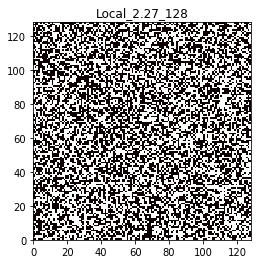

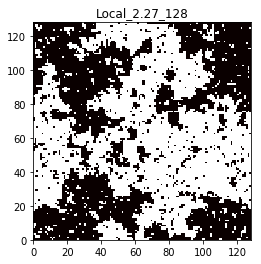

In [34]:
L=128        
N=L*L
T=2.27
nsteps=5000*N

filename="data_local_"+str(L)+"_"+str(T)+".txt" 
if os.path.isfile(filename):
    f=open(filename,"r")
    S=[]
    for line in f:
        S.append(int(line))
    f.close()
    print("Starting from file",filename)
else:
    S=[random.choice([-1,1]) for k in range(N)]
    print("Starting from a random configuration")
f=open(filename,"w")
for a in S: 
    f.write(str(a)+'\n')
f.close()

conf=[[0 for x in range(L)] for y in range(L)] 
for k in range(N):
    x,y=x_y(k,L)
    conf[x][y]=S[k]

plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

E=[]
beta=1/T
nbr={i:((i//L)*L+(i+1)%L,(i+L)%N,(i//L)*L+(i-1)%L,(i-L)%N) for i in range(N)}

Energy=energy(S,N,nbr)

for step in range(nsteps): 
        k=random.randint(0,N-1)
        delta_E=2.0*S[k]*sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0,1.0)<np.exp(-beta*delta_E): 
            S[k]*=-1 
            Energy+=delta_E
        E.append(Energy) 

for k in range(N): 
    x,y=x_y(k,L)
    conf[x][y]=S[k]
    
plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

#### Red de N=128x128 espines, T=Tc=2.27 y N*10000 iteraciones

Starting from file data_local_128_2.27.txt


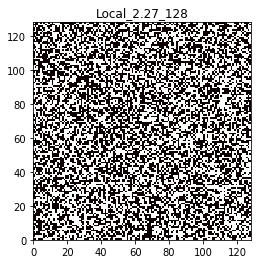

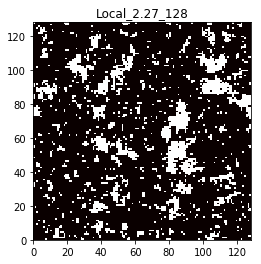

In [35]:
L=128        
N=L*L
T=2.27
nsteps=10000*N

filename="data_local_"+str(L)+"_"+str(T)+".txt" 
if os.path.isfile(filename):
    f=open(filename,"r")
    S=[]
    for line in f:
        S.append(int(line))
    f.close()
    print("Starting from file",filename)
else:
    S=[random.choice([-1,1]) for k in range(N)]
    print("Starting from a random configuration")
f=open(filename,"w")
for a in S: 
    f.write(str(a)+'\n')
f.close()

conf=[[0 for x in range(L)] for y in range(L)] 
for k in range(N):
    x,y=x_y(k,L)
    conf[x][y]=S[k]

plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

E=[]
beta=1/T
nbr={i:((i//L)*L+(i+1)%L,(i+L)%N,(i//L)*L+(i-1)%L,(i-L)%N) for i in range(N)}

Energy=energy(S,N,nbr)

for step in range(nsteps): 
        k=random.randint(0,N-1)
        delta_E=2.0*S[k]*sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0,1.0)<np.exp(-beta*delta_E): 
            S[k]*=-1 
            Energy+=delta_E
        E.append(Energy) 

for k in range(N): 
    x,y=x_y(k,L)
    conf[x][y]=S[k]
    
plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

<div style="text-align:justify"> 

Para el valor de la temperatura crítica de $Tc = T = 2.27$ se observa que al evolucionar el sistema de una configuración inicial aleatoria, este evoluciona hacia una configuración en la que empiezan a aparecer dominios magnéticos debido a la alineación de espines
</div>

#### Red de N=32x32 espines, T=1 y N*10000 iteraciones

Starting from file data_local_32_1.0.txt


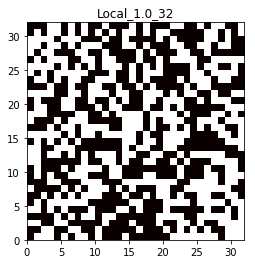

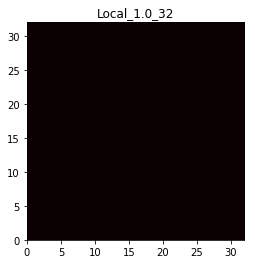

In [36]:
L=32        
N=L*L
T=1.0
nsteps=10000*N

filename="data_local_"+str(L)+"_"+str(T)+".txt" 
if os.path.isfile(filename):
    f=open(filename,"r")
    S=[]
    for line in f:
        S.append(int(line))
    f.close()
    print("Starting from file",filename)
else:
    S=[random.choice([-1,1]) for k in range(N)]
    print("Starting from a random configuration")
f=open(filename,"w")
for a in S: 
    f.write(str(a)+'\n')
f.close()

def x_y(k,L): 
    y=k//L
    x=k-y*L
    return x,y

conf=[[0 for x in range(L)] for y in range(L)] 
for k in range(N):
    x,y=x_y(k,L)
    conf[x][y]=S[k]

plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()


def energy(S,N,nbr): 
    E=0.0
    for k in range(N):
        E-=S[k]*sum(S[nn] for nn in nbr[k])
    return 0.5*E
E=[]
beta=1/T
nbr={i:((i//L)*L+(i+1)%L,(i+L)%N,(i//L)*L+(i-1)%L,(i-L)%N) for i in range(N)}

Energy=energy(S,N,nbr)

for step in range(nsteps): 
        k=random.randint(0,N-1)
        delta_E=2.0*S[k]*sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0,1.0)<np.exp(-beta*delta_E): 
            S[k]*=-1 
            Energy+=delta_E
        E.append(Energy) 

for k in range(N): 
    x,y=x_y(k,L)
    conf[x][y]=S[k]
    
plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

#### Red de N=64x64 espines, T=1 y N*10000 iteraciones

Starting from file data_local_64_1.0.txt


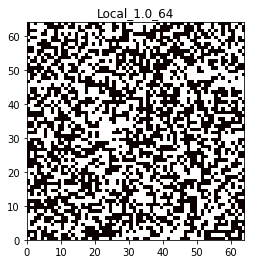

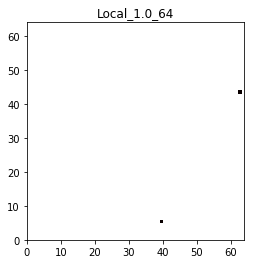

In [37]:
L=64        
N=L*L
T=1.0
nsteps=10000*N

filename="data_local_"+str(L)+"_"+str(T)+".txt" 
if os.path.isfile(filename):
    f=open(filename,"r")
    S=[]
    for line in f:
        S.append(int(line))
    f.close()
    print("Starting from file",filename)
else:
    S=[random.choice([-1,1]) for k in range(N)]
    print("Starting from a random configuration")
f=open(filename,"w")
for a in S: 
    f.write(str(a)+'\n')
f.close()

def x_y(k,L): 
    y=k//L
    x=k-y*L
    return x,y

conf=[[0 for x in range(L)] for y in range(L)] 
for k in range(N):
    x,y=x_y(k,L)
    conf[x][y]=S[k]

plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()


def energy(S,N,nbr): 
    E=0.0
    for k in range(N):
        E-=S[k]*sum(S[nn] for nn in nbr[k])
    return 0.5*E
E=[]
beta=1/T
nbr={i:((i//L)*L+(i+1)%L,(i+L)%N,(i//L)*L+(i-1)%L,(i-L)%N) for i in range(N)}

Energy=energy(S,N,nbr)

for step in range(nsteps): 
        k=random.randint(0,N-1)
        delta_E=2.0*S[k]*sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0,1.0)<np.exp(-beta*delta_E): 
            S[k]*=-1 
            Energy+=delta_E
        E.append(Energy) 

for k in range(N): 
    x,y=x_y(k,L)
    conf[x][y]=S[k]
    
plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

#### Red de N=128x128 espines, T=1 y N*10000 iteraciones

Starting from file data_local_128_1.0.txt


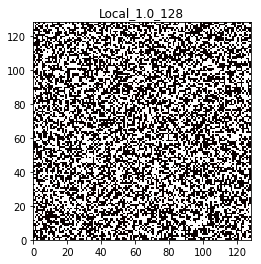

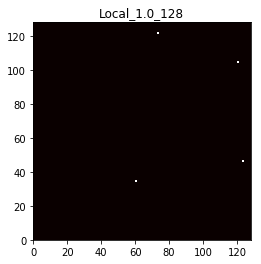

In [64]:
L=128        
N=L*L
T=1.0
nsteps=10000*N

filename="data_local_"+str(L)+"_"+str(T)+".txt" 
if os.path.isfile(filename):
    f=open(filename,"r")
    S=[]
    for line in f:
        S.append(int(line))
    f.close()
    print("Starting from file",filename)
else:
    S=[random.choice([-1,1]) for k in range(N)]
    print("Starting from a random configuration")
f=open(filename,"w")
for a in S: 
    f.write(str(a)+'\n')
f.close()

def x_y(k,L): 
    y=k//L
    x=k-y*L
    return x,y

conf=[[0 for x in range(L)] for y in range(L)] 
for k in range(N):
    x,y=x_y(k,L)
    conf[x][y]=S[k]

plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()


def energy(S,N,nbr): 
    E=0.0
    for k in range(N):
        E-=S[k]*sum(S[nn] for nn in nbr[k])
    return 0.5*E
E=[]
beta=1/T
nbr={i:((i//L)*L+(i+1)%L,(i+L)%N,(i//L)*L+(i-1)%L,(i-L)%N) for i in range(N)}

Energy=energy(S,N,nbr)

for step in range(nsteps): 
        k=random.randint(0,N-1)
        delta_E=2.0*S[k]*sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0,1.0)<np.exp(-beta*delta_E): 
            S[k]*=-1 
            Energy+=delta_E
        E.append(Energy) 

for k in range(N): 
    x,y=x_y(k,L)
    conf[x][y]=S[k]
    
plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

Starting from file data_local_128_1.0.txt


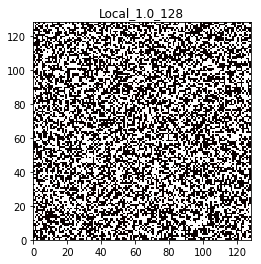

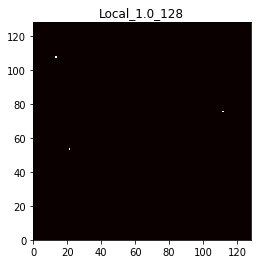

In [65]:
L=128        
N=L*L
T=1.0
nsteps=10000*N

filename="data_local_"+str(L)+"_"+str(T)+".txt" 
if os.path.isfile(filename):
    f=open(filename,"r")
    S=[]
    for line in f:
        S.append(int(line))
    f.close()
    print("Starting from file",filename)
else:
    S=[random.choice([-1,1]) for k in range(N)]
    print("Starting from a random configuration")
f=open(filename,"w")
for a in S: 
    f.write(str(a)+'\n')
f.close()

def x_y(k,L): 
    y=k//L
    x=k-y*L
    return x,y

conf=[[0 for x in range(L)] for y in range(L)] 
for k in range(N):
    x,y=x_y(k,L)
    conf[x][y]=S[k]

plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()


def energy(S,N,nbr): 
    E=0.0
    for k in range(N):
        E-=S[k]*sum(S[nn] for nn in nbr[k])
    return 0.5*E
E=[]
beta=1/T
nbr={i:((i//L)*L+(i+1)%L,(i+L)%N,(i//L)*L+(i-1)%L,(i-L)%N) for i in range(N)}

Energy=energy(S,N,nbr)

for step in range(nsteps): 
        k=random.randint(0,N-1)
        delta_E=2.0*S[k]*sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0,1.0)<np.exp(-beta*delta_E): 
            S[k]*=-1 
            Energy+=delta_E
        E.append(Energy) 

for k in range(N): 
    x,y=x_y(k,L)
    conf[x][y]=S[k]
    
plt.imshow(conf, extent=[0,L,0,L],interpolation='nearest') 
plt.set_cmap('hot')
plt.title(r'Local_'+str(T)+'_'+str(L))
plt.savefig('plotA2_local_'+str(T)+'_'+str(L)+'.png')
plt.show()

<div style="text-align:justify"> 

Para este caso, para temperaturas debajo de la temperatura crítica $Tc$ observamos que el sistema evoluciona a un estado ferromagnético con espines en una configurtación en la que están alineados.

</div>

<div style="text-align:justify"> 

La idea ahora es definir funciones que calculen el calor específico con métodos Montge Carlo y podamos graficar curvas de esta cantidad en función de la temperatura, la idea aquí será usar las líneas de código proveídas por el profesor Johans Restrepo.


</div>

<div style="text-align:justify"> 
    
   1. E_mean = sum(E) / len(E)


</div>

<div style="text-align:justify"> 

   2. E2_mean = sum(a ** 2 for a in E) / len(E)

</div>

<div style="text-align:justify"> 

   3. cv = (E2_mean - E_mean^2) / N / T^2

</div>

<div style="text-align:justify"> 
    
Primero vamos a construir una función que permita calcular los valores de E_mean y E2_mean, para un número de pasos Monte Carlo deseado, para una red de espines de tamaño $LxL$ a una temperatura $T$ dada


</div>

In [66]:
def Estates(T,L,MCsteps): #Vamos a obtener los valores de E_mean y E2_mean
    N=L*L
    nsteps=N*MCsteps
    S=[random.choice([-1,1]) for k in range(N)] #Configuracion inicial
    E=[]
    beta=float(1/T) #Número real, evitar errores
    nbr={i:((i//L)*L+(i+1)%L,(i+L)%N,(i//L)*L+(i-1)%L,(i-L)%N) for i in range(N)} 

    Energy=energy(S,N,nbr) #Energia de la configuración inicial

    for step in range(nsteps): 
            k=random.randint(0,N-1)
            delta_E=2.0*S[k]*sum(S[nn] for nn in nbr[k])
            if random.uniform(0.0,1.0)<np.exp(-beta*delta_E): 
                S[k]*=-1 
                Energy+=delta_E
            if float(step)/nsteps>0.40: #Descartar los primeros pasos, buscando el estado estable     
                E.append(Energy) 
    Energia=np.array(E)
    Energia2=Energia**2
    E_mean = sum(np.array(E))/float(len(np.array(E)))
    
    sum(Energia)/float(len(Energia))
    return [sum(Energia)/float(len(Energia)),sum(Energia2)/float(len(Energia2))]

<div style="text-align:justify"> 

Ahora usando la función anterior vamos a construir arreglos de Temperatura y de los valores de E_mean y E2_mean, arreglos de numpy que luego utilizaremos para construir las gráficas de calor específico
</div>

In [41]:
def E_mean_E_2_mean_cv(L,MCsteps):
    N= L*L
    T=np.linspace(0,5,MCsteps)
    E_mean=[]
    E2_mean=[]
    cv = []
    for Tpt in T:
        Est=Estates(Tpt,L,MCsteps)
        E_mean.append(Est[0])
        E2_mean.append(Est[1])
        Cv = (Est[1] - Est[0]**2)/N/Tpt
        cv.append(Cv)
    return [np.array(E_mean),np.array(E2_mean),np.array(cv)]

#### Gráficas de calor específico en función de la Temperatura

In [67]:
MCsteps = 2000
T=np.linspace(0,5,MCsteps)

In [68]:
y2 = E_mean_E_2_mean_cv(2,MCsteps)[2]
y3 = E_mean_E_2_mean_cv(3,MCsteps)[2]
y4 = E_mean_E_2_mean_cv(4,MCsteps)[2]


In [69]:
y8 = E_mean_E_2_mean_cv(8,MCsteps)[2]


In [70]:
y16 = E_mean_E_2_mean_cv(16,MCsteps)[2]

In [71]:
tc = 2 / np.log(1 + np.sqrt(2)) 
cvc = np.arange(0,5,0.01)
tc = np.ones(len(cvc))*tc

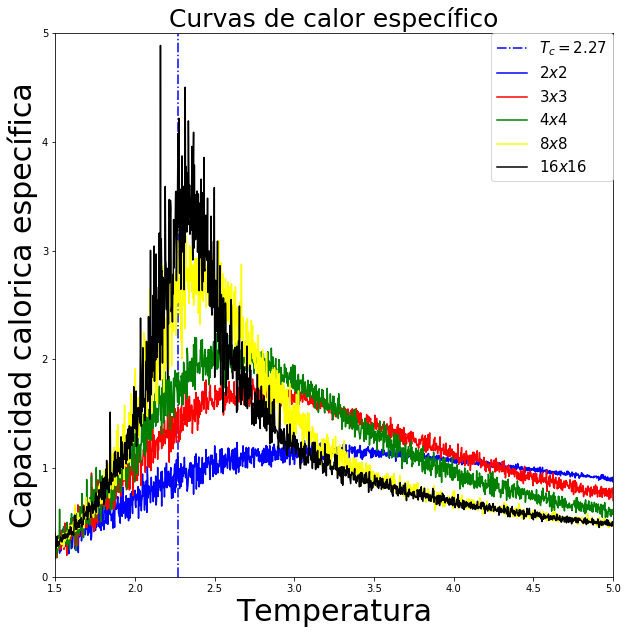

In [96]:
plt.figure(figsize=(10,10)) 

plt.plot(tc, cvc,linestyle='-.',label='$T_{c}=2.27$', color = "blue")
plt.plot(T,y2,label="$2 x 2$", color = 'blue')
plt.plot(T,y3,label="$3 x 3$", color = 'red')
plt.plot(T,y4,label="$4 x 4$", color = 'green')
plt.plot(T,y8,label="$8 x 8$", color = 'yellow')
plt.plot(T,y16,label="$16 x 16$", color = 'black')

plt.xlim(1.5,5)
plt.ylim(0,5)

plt.ylabel('Capacidad calorica específica',fontsize=30)
plt.xlabel('Temperatura',fontsize=30)
plt.title(r'Curvas de calor específico',fontsize=25)
plt.legend(loc=1,borderaxespad=0.,prop={'size': 15},fontsize=18)
plt.show()

<h2><left>3. Conclusiones</left></h2>
<div style="text-align:justify"> 
       
</div>

<div style="text-align:justify"> 
   
   1. El conteo de estados para el modelo de ising a fuerza bruta, es decir, calculando las energías y las configuraciones una por una, presenta grandes retos computacionales, pues el tiempo de computo crece rápidamente a medida que aumenta el número de espines en la red que se está estudiando, por ejemplo; en la máquina en que este notebook fue corrido, el problema para una red de $5x5$ espines no terminó de correr luego de 7 horas de cómputo, además como se observó en el informe, este parece tener un comportamiento exponencial 
       
</div>

<div style="text-align:justify"> 

   2. Los métodos Monte Carlo una vez más demuestran que son una herramienta altamente efectiva para tratar este tipo de problemas computacionales, pues como se vió en este notebook gracias a estos, se pudo tratar el problema alto dimensional de una red de $128x128$ espines
       
</div>

<div style="text-align:justify"> 
       
   3. El modelo de Ising es un modelo físico altamente educativo que permite visualizar de manera sencilla interacciones en sistemas físicos debido a su solición analítica, además este puede extrapolarse a otros porblemas de la vida cotidiana, al pensar el modelo como una interacción entre agentes, con dos posibles salidas (outputs)
   
</div>

<h2><left>Referencias</left></h2>
<div style="text-align:justify"> 


</div>

<div style="text-align:justify"> 

[1] https://es.wikipedia.org/wiki/Modelo_de_Ising

    
</div>

<div style="text-align:justify"> 

[2] http://blog.bjrn.se/2008/04/lexicographic-permutations-using.html
       
</div>

<div style="text-align:justify"> 

[3] W. Krauth. Statistical Mechanics: Algorithms and Computations. 2006. Oxford university press.

</div>

<h2><left>Agradecimientos</left></h2>
<div style="text-align:justify"> 
    
Una vez más un agradecimiento sincero al profesor Johans Restrepo, pues su orientación ha sido excelente para el entendimiento de un matemático que quiere aprender mucha física, además de su asesoría que ha sido oportuna para finalizar de manera correcta todos los cálculos que se encuentran dentro de este Notebook.
</div>

<div style="text-align:justify"> 
Agradecimiento especial al compañero del Grupo de Física Teórica y Matemática Aplicada Joseph Vergel, quién siempre ha dedicado unos momentos de su tiempo a mis dudas computacionales.
</div>